This code will create a market cap weighted portfolio of the 500 largest stocks by market cap and compute the monthly returns. We will then compare the top 10 stocks to the remaining 490 stocks. 
Lessons include: working with CRSP; using the groupby command and double indexes; how to compute weighted portfolio returns; and an analysis of returns to the top 10 stocks compared to market averages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd

The CRSP and Compustat files are stored and uploaded to Brightspace in a "feather" file format. This helps reduce the size. To read them into Python it is quite quick with the pd.read_feather command. Here I'll read in Compustat as well, although this program will only make use of CRSP. 

In [2]:
stocks = pd.read_feather('crsp_monthly_stocks.feather')
cstat  = pd.read_feather('compustat_annual.feather')

The dataframe contains one row for each stock/month -- sorted first by PERMNO, then by DATE. The other fields are SHRCD (10 and 11 for commmon stocks), EXCHCD (which exchange they are listed on), SICCD (industry), PRC (price), VOL (volume), RET (return over the month, including dividends), SPREAD (the bid/ask spread -- although note that this data field contains a lot of missing values), RETX (the monthly return without the dividend), and SHROUT (shares outstanding). 

In [3]:
stocks.head()

,PERMNO,DATE,SHRCD,EXCHCD,SICCD,PRC,VOL,RET,SPREAD,RETX,SHROUT
0,10000.0,1986-01-31,10.0,3.0,3990.0,-4.375000,1771.0,NaN,0.25000,NaN,3680.0
1,10000.0,1986-02-28,10.0,3.0,3990.0,-3.250000,828.0,-0.257143,0.25000,-0.257143,3680.0
2,10000.0,1986-03-31,10.0,3.0,3990.0,-4.437500,1078.0,0.365385,0.12500,0.365385,3680.0
3,10000.0,1986-04-30,10.0,3.0,3990.0,-4.000000,957.0,-0.098592,0.25000,-0.098592,3793.0
4,10000.0,1986-05-30,10.0,3.0,3990.0,-3.109375,1074.0,-0.222656,0.09375,-0.222656,3793.0


Note that the stock/months are all stacked on top of one another. Be careful -- if we are to just apply things like the shift function or try to compute moving averages of the prices, we may inadvertantly refer to the prior company's data.This would be bad!

In [4]:
stocks.iloc[390:405]

,PERMNO,DATE,SHRCD,EXCHCD,SICCD,PRC,VOL,RET,SPREAD,RETX,SHROUT
390,10001.0,2017-01-31,11.0,2.0,4925.0,12.6500,9297.0,0.007968,NaN,0.007968,10520.0
391,10001.0,2017-02-28,11.0,2.0,4925.0,12.6500,3979.0,0.000000,NaN,0.000000,10520.0
392,10001.0,2017-03-31,11.0,2.0,4925.0,12.7000,6335.0,0.009881,NaN,0.003953,10520.0
393,10001.0,2017-04-28,11.0,2.0,4925.0,12.5000,3906.0,-0.015748,NaN,-0.015748,10520.0
394,10001.0,2017-05-31,11.0,2.0,4925.0,12.7000,4401.0,0.016000,NaN,0.016000,10520.0
395,10001.0,2017-06-30,11.0,2.0,4925.0,12.9250,5909.0,0.023622,NaN,0.017717,10520.0
396,10001.0,2017-07-31,11.0,2.0,4925.0,12.9500,8269.0,0.001934,NaN,0.001934,10520.0
397,10001.0,2017-08-31,11.0,2.0,4925.0,NaN,7035.0,NaN,NaN,NaN,10520.0
398,10002.0,1986-01-31,10.0,3.0,6710.0,-11.6250,1284.0,NaN,0.250,NaN,1175.0
399,10002.0,1986-02-28,10.0,3.0,6710.0,-13.2500,1351.0,0.139785,0.250,0.139785,1175.0


Here's the Compustat file -- each row contains one fiscal years worth of data for a firm

In [5]:
cstat.head()

,DATADATE,FYEAR,LPERMNO,AT,CEQ,CHE,LT,PSTK,SEQ,DVT,IB,SALE,CAPX
0,1970-12-31,1970.0,25881.0,33.450,10.544,1.660,22.906,0.000,10.544,0.000,1.878,45.335,2.767
1,1971-12-31,1971.0,25881.0,29.330,8.381,2.557,20.948,0.000,8.382,0.000,0.138,47.033,1.771
2,1972-12-31,1972.0,25881.0,19.907,7.021,2.027,12.886,0.000,7.021,0.000,1.554,34.362,1.254
3,1973-12-31,1973.0,25881.0,21.771,8.567,1.357,13.204,0.000,8.567,0.000,1.863,37.750,1.633
4,1974-12-31,1974.0,25881.0,25.638,9.843,1.338,15.381,0.414,10.257,0.021,1.555,50.325,1.313


In order to avoid mixing up data across stocks, we can use a double index. If we give our set_index command two data fields, they will both be indexes -- index level 1, index level 2. We can also fix the PRC field to be positive, and compute market cap. Note that the Market Cap field, as calculated, uses the end-of-month price. If we are to use this to form portfolios, that will then induce look-ahead bias! So let's also lag that field. Here we use the groupby command. This means that we apply the shift function to each PERMNO group, but we don't apply shift across PERMNOs. 

In [6]:
stocks.set_index(['PERMNO','DATE'], inplace=True)
stocks.sort_index(inplace=True)

stocks['PRC']=abs(stocks['PRC'])
stocks['mkcap']=stocks['PRC']*stocks['SHROUT'] 
stocks['lag MC']  = stocks['mkcap'].groupby('PERMNO').shift(1)

Note that our groupby function works here -- the first entry for PERMNO 10001 does not receive a 'lag MC' equal to the final market cap of PERMNO 10000. 

In [7]:
stocks.head(30)

SHRCD  EXCHCD   SICCD       PRC     VOL       RET  \
PERMNO  DATE                                                            
10000.0 1986-01-31   10.0     3.0  3990.0  4.375000  1771.0       NaN   
        1986-02-28   10.0     3.0  3990.0  3.250000   828.0 -0.257143   
        1986-03-31   10.0     3.0  3990.0  4.437500  1078.0  0.365385   
        1986-04-30   10.0     3.0  3990.0  4.000000   957.0 -0.098592   
        1986-05-30   10.0     3.0  3990.0  3.109375  1074.0 -0.222656   
        1986-06-30   10.0     3.0  3990.0  3.093750  1069.0 -0.005025   
        1986-07-31   10.0     3.0  3990.0  2.843750  1163.0 -0.080808   
        1986-08-29   10.0     3.0  3990.0  1.093750  3049.0 -0.615385   
        1986-09-30   10.0     3.0  3990.0  1.031250  3551.0 -0.057143   
        1986-10-31   10.0     3.0  3990.0  0.781250  1903.0 -0.242424   
        1986-11-28   10.0     3.0  3990.0  0.828125  2113.0  0.060000   
        1986-12-31   10.0     3.0  3990.0  0.515625  3215.0 -0.377358   
        1987-01-30   10.0     3.0  3990.0  0.406250  1754.0 -0.212121   
        1987-02-27   10.0     3.0  3990.0  0.406250   392.0  0.000000   
        1987-03-31   10.0     3.0  3990.0  0.250000  1111.0 -0.384615   
        1987-04-30   10.0     3.0  3990.0  0.234375   998.0 -0.062500   
        1987-05-29   10.0     3.0  3990.0  0.218750   815.0 -0.066667   
        1987-06-30   10.0     3.0  3990.0       NaN    67.0       NaN   
10001.0 1986-01-31   11.0     3.0  4920.0  6.125000   667.0       NaN   
        1986-02-28   11.0     3.0  4920.0  6.250000  1067.0  0.020408   
        1986-03-31   11.0     3.0  4920.0  6.312500   335.0  0.025200   
        1986-04-30   11.0     3.0  4920.0  6.375000   225.0  0.009901   
        1986-05-30   11.0     3.0  4920.0  6.312500   217.0 -0.009804   
        1986-06-30   11.0     3.0  4920.0  6.125000   238.0 -0.013069   
        1986-07-31   11.0     3.0  4920.0  6.062500   429.0 -0.010204   
        1986-08-29   11.0     3.0  4920.0  6.500000   895.0  0.072165   
        1986-09-30   11.0     3.0  4920.0  6.375000   366.0 -0.003077   
        1986-10-31   11.0     3.0  4920.0  6.625000   362.0  0.039216   
        1986-11-28   11.0     3.0  4920.0  7.000000   312.0  0.056604   
        1986-12-31   11.0     3.0  4920.0  7.000000   312.0  0.015000   

                     SPREAD      RETX  SHROUT         mkcap        lag MC  
PERMNO  DATE                                                               
10000.0 1986-01-31  0.25000       NaN  3680.0  16100.000000           NaN  
        1986-02-28  0.25000 -0.257143  3680.0  11960.000000  16100.000000  
        1986-03-31  0.12500  0.365385  3680.0  16330.000000  11960.000000  
        1986-04-30  0.25000 -0.098592  3793.0  15172.000000  16330.000000  
        1986-05-30  0.09375 -0.222656  3793.0  11793.859375  15172.000000  
        1986-06-30  0.06250 -0.005025  3793.0  11734.593750  11793.859375  
        1986-07-31  0.06250 -0.080808  3793.0  10786.343750  11734.593750  
        1986-08-29  0.06250 -0.615385  3793.0   4148.593750  10786.343750  
        1986-09-30  0.06250 -0.057143  3793.0   3911.531250   4148.593750  
        1986-10-31  0.06250 -0.242424  3843.0   3002.343750   3911.531250  
        1986-11-28  0.09375  0.060000  3843.0   3182.484375   3002.343750  
        1986-12-31  0.09375 -0.377358  3843.0   1981.546875   3182.484375  
        1987-01-30  0.06250 -0.212121  3893.0   1581.531250   1981.546875  
        1987-02-27  0.06250  0.000000  3893.0   1581.531250   1581.531250  
        1987-03-31  0.06250 -0.384615  3893.0    973.250000   1581.531250  
        1987-04-30  0.03125 -0.062500  3893.0    912.421875    973.250000  
        1987-05-29  0.06250 -0.066667  3893.0    851.593750    912.421875  
        1987-06-30      NaN       NaN  3893.0           NaN    851.593750  
10001.0 1986-01-31  0.25000       NaN   985.0   6033.125000           NaN  
        1986-02-28  0.25000  0.020408   985.0   6156.250000   6033.125000  
        198

We can use the rank function to give the ordering for each stock each month. Using the 'ascending=False' parameter will reverse the sort so that the largest stock will get a rank of 1 and the smallest will get a rank of N. Here we are using a groupby on date -- so each date, we are ranking the PERMNOs by thier lagged market cap. 

In [8]:
stocks['rank'] = stocks['lag MC'].groupby('DATE').rank(ascending=False)

PERMNO 14593 corresponds to Apple. We can look at that as an example and see that it is now ranked #1 as the largest stock (2.7 Trillion USD market cap) while back in the 1980's it was in the mid-100s range.

In [9]:
stocks.loc[14593]

,SHRCD,EXCHCD,SICCD,PRC,VOL,RET,SPREAD,RETX,SHROUT,mkcap,lag MC,rank
DATE,,,,,,,,,,,,
1980-12-31,11.0,3.0,3573.0,34.187500,NaN,NaN,0.125,NaN,55136.0,1.884962e+06,NaN,NaN
1981-01-30,11.0,3.0,3573.0,28.375000,NaN,-0.170018,0.250,-0.170018,55136.0,1.564484e+06,1.884962e+06,130.0
1981-02-27,11.0,3.0,3573.0,26.625000,NaN,-0.061674,0.250,-0.061674,55136.0,1.467996e+06,1.564484e+06,152.0
1981-03-31,11.0,3.0,3573.0,24.625000,NaN,-0.075117,0.250,-0.075117,55136.0,1.357724e+06,1.467996e+06,165.0
1981-04-30,11.0,3.0,3573.0,28.500000,NaN,0.157360,0.250,0.157360,55136.0,1.571376e+06,1.357724e+06,203.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28,11.0,3.0,3571.0,147.410004,13119369.0,0.023217,NaN,0.021623,15821946.0,2.332313e+09,2.282948e+09,1.0
2023-03-31,11.0,3.0,3571.0,164.899994,15192862.0,0.118649,NaN,0.118649,15723406.0,2.592790e+09,2.332313e+09,1.0
2023-04-28,11.0,3.0,3571.0,169.679993,9696102.0,0.028987,NaN,0.028987,15728702.0,2.668846e+09,2.592790e+09,1.0


Now restrict the universe to only those ranked from 1 to 500. 

In [10]:
stocks=stocks.loc[stocks['rank'] < 501]

In [33]:
stocks.head(50)

SHRCD  EXCHCD   SICCD      PRC     VOL       RET  SPREAD  \
PERMNO  DATE                                                                   
10006.0 1962-02-28   10.0     1.0  3740.0   73.250   458.0  0.011986     NaN   
        1962-03-30   10.0     1.0  3740.0   68.000   418.0 -0.071672     NaN   
        1962-04-30   10.0     1.0  3740.0   71.875   626.0  0.056985     NaN   
        1962-05-31   10.0     1.0  3740.0   59.750   826.0 -0.160000     NaN   
        1962-06-29   10.0     1.0  3740.0   59.000   397.0 -0.012552     NaN   
        1962-07-31   10.0     1.0  3743.0   67.500   381.0  0.144068     NaN   
        1962-08-31   10.0     1.0  3743.0   67.125   377.0  0.003704     NaN   
        1962-09-28   10.0     1.0  3743.0   63.500   321.0 -0.054004     NaN   
        1962-10-31   10.0     1.0  3743.0   68.000   402.0  0.070866     NaN   
        1962-11-30   10.0     1.0  3743.0   72.875   621.0  0.080882     NaN   
        1962-12-31   10.0     1.0  3743.0   77.125   289.0  0.058319     NaN   
        1963-01-31   10.0     1.0  3743.0   80.750   506.0  0.047002     NaN   
        1963-02-28   10.0     1.0  3743.0   83.250   351.0  0.038700     NaN   
        1963-03-29   10.0     1.0  3743.0   82.500   491.0 -0.009009     NaN   
        1963-04-30   10.0     1.0  3743.0   89.500   374.0  0.084848     NaN   
        1963-05-31   10.0     1.0  3743.0   97.000   375.0  0.091620     NaN   
        1963-06-28   10.0     1.0  3743.0   96.875   291.0 -0.001289    0.25   
        1963-07-31   10.0     1.0  3743.0   92.500   243.0 -0.045161     NaN   
        1963-08-30   10.0     1.0  3743.0  103.000   303.0  0.121081     NaN   
        1963-09-30   10.0     1.0  3743.0   47.500   335.0 -0.077670     NaN   
        1963-10-31   10.0     1.0  3743.0   50.250   658.0  0.057895     NaN   
        1963-11-29   10.0     1.0  3743.0   62.250   611.0  0.246766     NaN   
        1963-12-31   10.0     1.0  3743.0   62.000   493.0 -0.004016     NaN   
        1964-01-31   10.0     1.0  3743.0   66.250   715.0  0.068548     NaN   
        1964-02-28   10.0     1.0  3743.0   68.750   581.0  0.043774     NaN   
        1964-03-31   10.0     1.0  3743.0   68.750   698.0  0.000000     NaN   
        1964-04-30   10.0     1.0  3743.0   69.000   695.0  0.003636     NaN   
        1964-05-28   10.0     1.0  3743.0   67.750   375.0 -0.010870     NaN   
        1964-06-30   10.0     1.0  3743.0   72.875   446.0  0.075646     NaN   
        1964-07-31   10.0     1.0  3743.0   78.250   427.0  0.073756     NaN   
        1964-08-31   10.0     1.0  3743.0   78.625   533.0  0.012780     NaN   
        1964-09-30   10.0     1.0  3743.0   84.500   773.0  0.074722     NaN   
        1964-10-30   10.0     1.0  3743.0   87.000   455.0  0.029586     NaN   
        1964-11-30   10.0     1.0  3743.0   84.250   417.0 -0.023276     NaN   
        1964-12-31   10.0     1.0  3743.0   79.500   632.0 -0.056380     NaN   
        1965-01-29   10.0     1.0  3743.0   83.750   597.0  0.053459     NaN   
        1965-02-26   10.0     1.0  3743.0   80.750   554.0 -0.025970     NaN   
        1965-03-31   10.0     1.0  3743.0   84.000   892.0  0.040248     NaN   
        1965-04-30   10.0     1.0  3743.0   91.125   621.0  0.084821     NaN   
        1965-05-28   10.0     1.0  3743.0   86.250   656.0 -0.043621     NaN   
        1965-06-30   10.0     1.0  3743.0   77.250   564.0 -0.104348     NaN   
        1965-07-30   10.0     1.0  3743.0   78.000   617.0  0.009709     NaN   
        1965-08-31   10.0     1.0  3743.0   81.750   994.0  0.059615     NaN   
        1965-09-30   10.0     1.0  3743.0   40.375  1733.0 -0.012232     NaN   
        1965-10-29   10.0     1.0  3743.0   44.750  2265.0  0.108359     NaN   
        1965-11-30   10.0     1.0  3743.0   43.875  1403.0 -0.009497     NaN   
        1965-12-31   10.0     1.0  3743.0   47.250  1748.0  0.076923     NaN   
        1966-01-31   10.0     1.0  3743.0   51.500  1759.0  0.089947     NaN   
        1966-02-28  

Next we will compute monthly returns for the following portfolios: 
1. Equally weighted top 500 stocks
2. Market Cap weighted top 500 stocks
3. Market Cap weighted top 10 stocks
4. Market Cap weighted stocks 11-500

The first is easy. We just need to take the mean return across all stocks for each date. 

In [11]:
EWport = stocks['RET'].groupby('DATE').mean()
EWport

DATE
1962-02-28    0.016251
1962-03-30   -0.006515
1962-04-30   -0.063585
1962-05-31   -0.093275
1962-06-29   -0.084265
                ...   
2023-02-28   -0.028684
2023-03-31    0.003774
2023-04-28   -0.005088
2023-05-31   -0.020954
2023-06-30    0.073904
Name: RET, Length: 737, dtype: float64

To do a market cap weighted portfolio, we need to first compute some weights. And be careful about look-ahead bias! First we will compute the total market cap for each date, and then each stocks weight will be the corresponding percentage that it accounts for in our data set. 

In [12]:
totalmkt=stocks['lag MC'].groupby('DATE').sum()
totalmkt

DATE
1962-02-28    3.348222e+08
1962-03-30    3.414924e+08
1962-04-30    3.394017e+08
1962-05-31    3.179713e+08
1962-06-29    2.901147e+08
                  ...     
2023-02-28    3.526840e+10
2023-03-31    3.436815e+10
2023-04-28    3.561793e+10
2023-05-31    3.603570e+10
2023-06-30    3.635222e+10
Name: lag MC, Length: 737, dtype: float64

In [13]:
stocks['MCwt'] = stocks['lag MC'] / stocks['lag MC'].groupby('DATE').sum()

check to be sure that my weights sum up to 1 for each period

In [14]:
stocks['MCwt'].groupby('DATE').sum()

DATE
1962-02-28    1.0
1962-03-30    1.0
1962-04-30    1.0
1962-05-31    1.0
1962-06-29    1.0
             ... 
2023-02-28    1.0
2023-03-31    1.0
2023-04-28    1.0
2023-05-31    1.0
2023-06-30    1.0
Name: MCwt, Length: 737, dtype: float64

Our portfolio returns are then the sum product of each stock's weights times the returns

In [15]:
stocks['ret500']=stocks['RET']*stocks['MCwt']

In [16]:
port500 = stocks['ret500'].groupby('DATE').sum()

In [17]:
port500

DATE
1962-02-28    0.020601
1962-03-30   -0.004561
1962-04-30   -0.062855
1962-05-31   -0.082785
1962-06-29   -0.082468
                ...   
2023-02-28   -0.022508
2023-03-31    0.038828
2023-04-28    0.012965
2023-05-31    0.009864
2023-06-30    0.066368
Name: ret500, Length: 737, dtype: float64

Now let's take a quicklook at the returns for the top 500 stocks weighted by market cap and by equal weight. Note that the returns and the volatility are both higher for the equal weight portfolio. This is consistent with the size effect and SMB factor -- small cap stocks tend to outperform large cap stocks, and with more volatility. 

In [18]:
port500.describe()

count    737.000000
mean       0.008955
std        0.043564
min       -0.210373
25%       -0.015811
50%        0.012349
75%        0.036686
max        0.176882
Name: ret500, dtype: float64

In [19]:
EWport.describe()

count    737.000000
mean       0.009637
std        0.047384
min       -0.229095
25%       -0.018721
50%        0.012541
75%        0.039007
max        0.177519
Name: RET, dtype: float64

What about the results of the top 10 stocks and the other 490? We can split our universe fairly easily and then compute these returns as well. Note that we can't just directly apply the market cap weights we have already calculated, though. If we do that, the total weights will not sum to 1. 

In [20]:
top10=stocks.loc[stocks['rank'] < 11]
top490 = stocks.loc[stocks['rank'] > 10]

Let's check and see how the concentration risk (how much of the S&P 500 is in the top 10 stocks) has varied over time: 

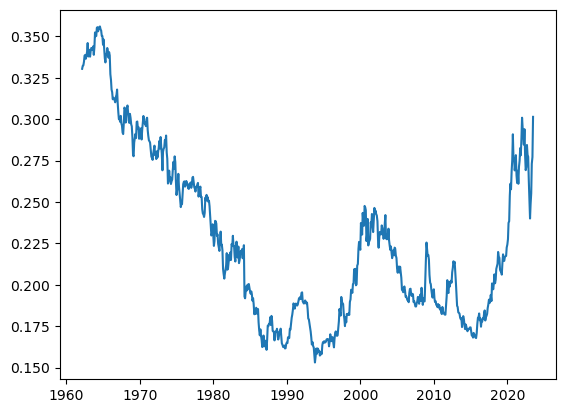

In [21]:
plt.plot(top10['MCwt'].groupby('DATE').sum())

In [22]:
top10['MCwt2'] = top10['lag MC'] / top10['lag MC'].groupby('DATE').sum()
top490['MCwt2'] = top490['lag MC'] / top490['lag MC'].groupby('DATE').sum()

/var/folders/76/7ftvty753sx628h00l7k3dy80000gn/T/ipykernel_44770/2259662859.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top10['MCwt2'] = top10['lag MC'] / top10['lag MC'].groupby('DATE').sum()
/var/folders/76/7ftvty753sx628h00l7k3dy80000gn/T/ipykernel_44770/2259662859.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top490['MCwt2'] = top490['lag MC'] / top490['lag MC'].groupby('DATE').sum()


In [23]:
top10['ret10']=top10['RET']*top10['MCwt2']
top490['ret490']=top490['RET']*top490['MCwt2']
port10 = top10['ret10'].groupby('DATE').sum()
port490 = top490['ret490'].groupby('DATE').sum()

/var/folders/76/7ftvty753sx628h00l7k3dy80000gn/T/ipykernel_44770/384170909.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top10['ret10']=top10['RET']*top10['MCwt2']
/var/folders/76/7ftvty753sx628h00l7k3dy80000gn/T/ipykernel_44770/384170909.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top490['ret490']=top490['RET']*top490['MCwt2']


The concat function will allow us to put all of these return series into a single dataframe.

In [24]:
portfolios = pd.concat([port500, EWport, port10, port490],axis=1)
portfolios.rename(columns={'RET':'EW'},inplace=True)

In [25]:
portfolios

,ret500,EW,ret10,ret490
DATE,,,,
1962-02-28,0.020601,0.016251,0.031477,0.015233
1962-03-30,-0.004561,-0.006515,-0.004990,-0.004348
1962-04-30,-0.062855,-0.063585,-0.056640,-0.065952
1962-05-31,-0.082785,-0.093275,-0.071072,-0.088680
1962-06-29,-0.082468,-0.084265,-0.076273,-0.085638
...,...,...,...,...
2023-02-28,-0.022508,-0.028684,-0.000426,-0.029816
2023-03-31,0.038828,0.003774,0.102528,0.016992
2023-04-28,0.012965,-0.005088,0.027103,0.007654


Let's look at the annualzied returns and sharpe ratios for all these portfolios

In [26]:
portfolios.describe()

,ret500,EW,ret10,ret490
count,737.000000,737.000000,737.000000,737.000000
mean,0.008955,0.009637,0.008574,0.009090
std,0.043564,0.047384,0.045586,0.044756
min,-0.210373,-0.229095,-0.191954,-0.214299
25%,-0.015811,-0.018721,-0.016313,-0.016566
50%,0.012349,0.012541,0.009105,0.013070
75%,0.036686,0.039007,0.035527,0.037082
max,0.176882,0.177519,0.164754,0.194826


Let's create a new dataframe for the annualized means and sharpe ratios

In [27]:
portmeans=portfolios.describe()
portmeans.loc['mean']=portmeans.loc['mean']*12
portmeans.loc['std']=portmeans.loc['std']*np.sqrt(12)
portmeans.loc['sharpe*'] = portmeans.loc['mean']/portmeans.loc['std']

In [28]:
portmeans

,ret500,EW,ret10,ret490
count,737.000000,737.000000,737.000000,737.000000
mean,0.107455,0.115644,0.102893,0.109081
std,0.150909,0.164142,0.157913,0.155040
min,-0.210373,-0.229095,-0.191954,-0.214299
25%,-0.015811,-0.018721,-0.016313,-0.016566
50%,0.012349,0.012541,0.009105,0.013070
75%,0.036686,0.039007,0.035527,0.037082
max,0.176882,0.177519,0.164754,0.194826
sharpe*,0.712050,0.704536,0.651582,0.703563


So the top 10 stocks have underperformed the other 490 by an average of about 60 bps per year. And they have done so with more volatility!

Next let's just reproduce the chart we saw a the beginning of class

In [29]:
portCum = portfolios+1
portCum = portCum.cumprod(skipna=True)

In [30]:
portCum.drop(['EW','ret10'],axis=1,inplace=True)

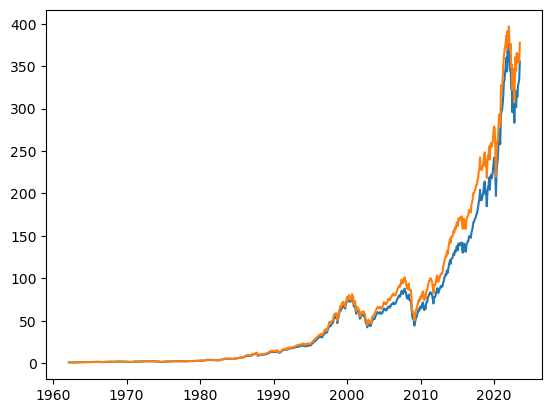

In [31]:
plt.plot(portCum)

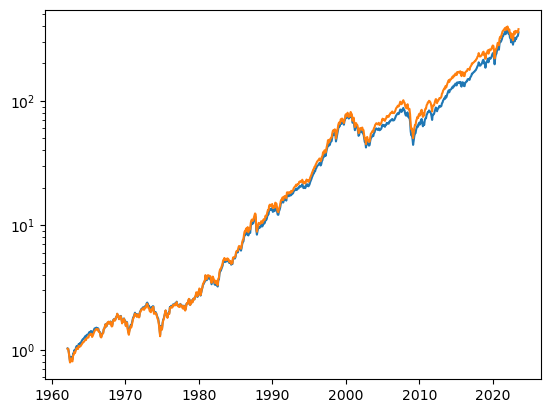

In [32]:
plt.yscale('log')
plt.plot(portCum)